In [1]:
import kaggle

kaggle.api.authenticate()
kaggle.api.dataset_download_files('elvis23/mental-health-conversational-data', path='.', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/elvis23/mental-health-conversational-data


In [5]:
import json
import pandas as pd

with open('intents.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data['intents'])

In [6]:
dic = {"tag":[], "patterns":[], "responses":[]}
for i in range(len(df)):
    ptrns = df[df.index == i]['patterns'].values[0]
    rspns = df[df.index == i]['responses'].values[0]
    tag = df[df.index == i]['tag'].values[0]
    for j in range(len(ptrns)):
        dic['tag'].append(tag)
        dic['patterns'].append(ptrns[j])
        dic['responses'].append(rspns)
        
df = pd.DataFrame.from_dict(dic)
df

,tag,patterns,responses
0,greeting,Hi,[Hello there. Tell me how are you feeling toda...
1,greeting,Hey,[Hello there. Tell me how are you feeling toda...
2,greeting,Is anyone there?,[Hello there. Tell me how are you feeling toda...
3,greeting,Hi there,[Hello there. Tell me how are you feeling toda...
4,greeting,Hello,[Hello there. Tell me how are you feeling toda...
...,...,...,...
227,fact-29,How do I know if I'm unwell?,"[If your beliefs , thoughts , feelings or beha..."
228,fact-30,How can I maintain social connections? What if...,"[A lot of people are alone right now, but we d..."
229,fact-31,What's the difference between anxiety and stress?,[Stress and anxiety are often used interchange...
230,fact-32,What's the difference between sadness and depr...,"[Sadness is a normal reaction to a loss, disap..."


In [7]:
df_responses = df.explode('responses')
all_patterns = ' '.join(df['patterns'])

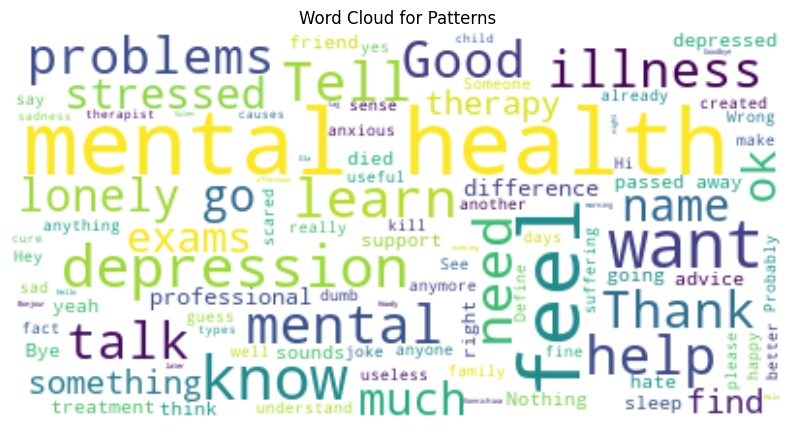

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

wordcloud = WordCloud(background_color='white', max_words=100, contour_width=3, contour_color='steelblue').generate(all_patterns)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Patterns')
plt.show()

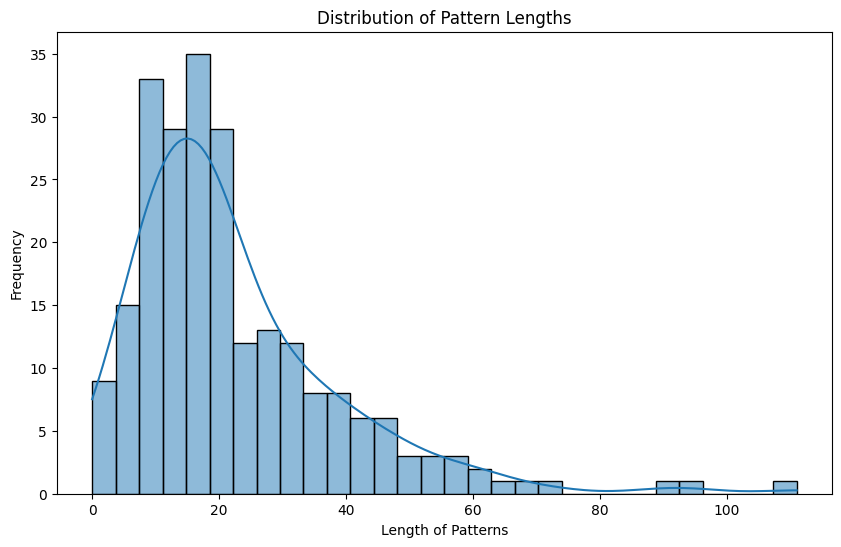

In [9]:
df['pattern_length'] = df['patterns'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['pattern_length'], bins=30, kde=True)
plt.title('Distribution of Pattern Lengths')
plt.xlabel('Length of Patterns')
plt.ylabel('Frequency')
plt.show()

In [10]:
import re

def preprocess_text(s):
    s = re.sub('[^a-zA-Z\']', ' ', s) 
    s = s.lower()
    s = s.split()
    s = " ".join(s)
    return s

df['patterns'] = df['patterns'].apply(preprocess_text)
df['tag'] = df['tag'].apply(preprocess_text)
df

,tag,patterns,responses,pattern_length
0,greeting,hi,[Hello there. Tell me how are you feeling toda...,2
1,greeting,hey,[Hello there. Tell me how are you feeling toda...,3
2,greeting,is anyone there,[Hello there. Tell me how are you feeling toda...,16
3,greeting,hi there,[Hello there. Tell me how are you feeling toda...,8
4,greeting,hello,[Hello there. Tell me how are you feeling toda...,5
...,...,...,...,...
227,fact,how do i know if i'm unwell,"[If your beliefs , thoughts , feelings or beha...",28
228,fact,how can i maintain social connections what if ...,"[A lot of people are alone right now, but we d...",61
229,fact,what's the difference between anxiety and stress,[Stress and anxiety are often used interchange...,49
230,fact,what's the difference between sadness and depr...,"[Sadness is a normal reaction to a loss, disap...",53


In [11]:
df['tag'].unique()

array(['greeting', 'morning', 'afternoon', 'evening', 'night', 'goodbye',
       'thanks', 'no response', 'neutral response', 'about', 'skill',
       'creation', 'name', 'help', 'sad', 'stressed', 'worthless',
       'depressed', 'happy', 'casual', 'anxious', 'not talking', 'sleep',
       'scared', 'death', 'understand', 'done', 'suicide', 'hate you',
       'hate me', 'default', 'jokes', 'repeat', 'wrong', 'stupid',
       'location', 'something else', 'friends', 'ask', 'problem',
       'no approach', 'learn more', 'user agree', 'meditation',
       'user meditation', 'pandora useful', 'user advice',
       'learn mental health', 'mental health fact', 'fact'], dtype=object)

In [12]:
len(df['tag'].unique())

50

In [13]:
X = df['patterns']
y = df['tag']

# Build Model

In [16]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [ ]:
# Tokenization and Encoding the Data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128 

def encode_texts(texts, max_len):
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

C:\Users\sasya\AppData\Roaming\Python\Python313\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sasya\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [18]:
# Encoding labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_labels = len(np.unique(y_encoded))

# Encode the patterns
input_ids, attention_masks = encode_texts(X, max_len)
labels = torch.tensor(y_encoded)

# Splitting the dataset into training and validation
dataset = torch.utils.data.TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
validation_dataloader = DataLoader(val_dataset, batch_size=16)

# Model and Optimization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
optimizer = AdamW(model.parameters(), lr=2e-5)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\sasya\AppData\Roaming\Python\Python313\site-packages\transformers\tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not install

In [19]:
# training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        model.zero_grad()        
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_train_loss / len(train_dataloader)            
    print(f"Epoch {epoch+1}, Average Training Loss: {avg_train_loss:.2f}")

Epoch 1, Average Training Loss: 3.86
Epoch 2, Average Training Loss: 3.61
Epoch 3, Average Training Loss: 3.41
Epoch 4, Average Training Loss: 3.20
Epoch 5, Average Training Loss: 3.01
Epoch 6, Average Training Loss: 2.85


KeyboardInterrupt: 